# Временные ряды
## Домашнее задание №3

<pre>
ФИО: Никифоров Владимир
</pre>

- Выберите ряд и постройте его модель ARIMA/GARCH.
- **Не обязательное дз.** Попробуйте спрогнозировать график классическим ML

In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from arch import arch_model

/home/truename/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [4]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [5]:
df = pd.read_csv('../data/monthly-sales-of-company-x-jan-6.csv').dropna()
series = df['Count']
df.head()

,Month,Count
0,1965-01,154
1,1965-02,96
2,1965-03,73
3,1965-04,49
4,1965-05,36


Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


/home/truename/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


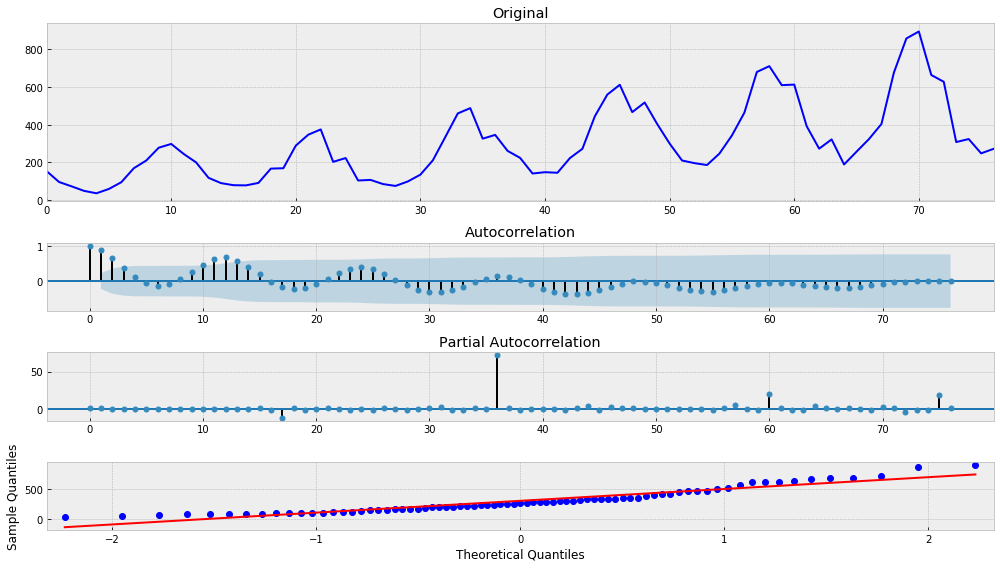

In [6]:
tsplot(series)

Ряд характеризуется ростом во времени дисперсии и сезонностью.

Применим преобразование Бокса-Кокса и дифференцирование:

Results of Dickey-Fuller Test:
Test Statistic                 -3.135644
p-value                         0.024025
#Lags Used                     11.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


/home/truename/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


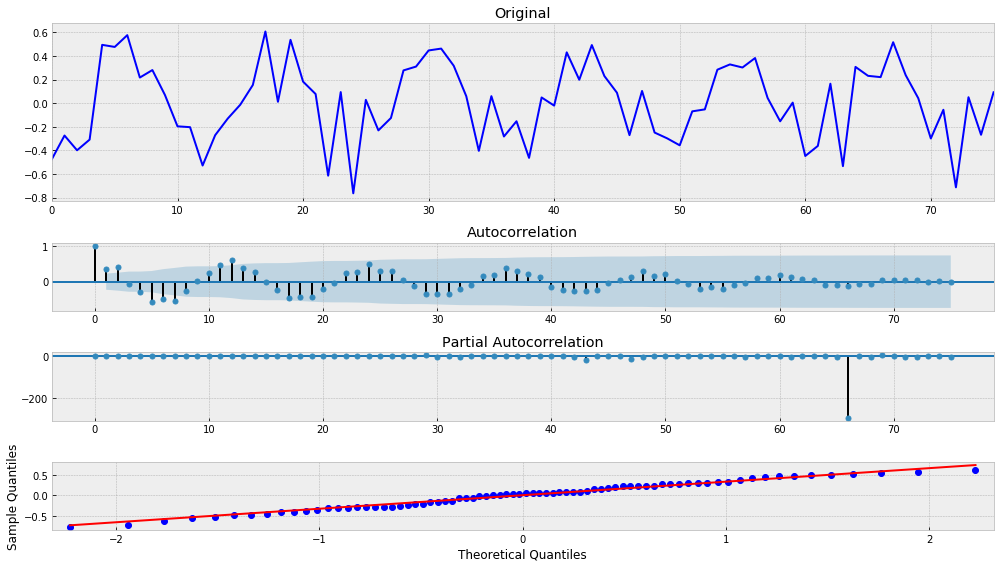

In [7]:
series = boxcox(series, 0)
series = series[1:] - series[:-1]
tsplot(series)

Применим ARIMA к нашему временному ряду

In [8]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

aic, order, mdl = _get_best_model(series)

aic: -33.21456 | order: (3, 0, 2)


Results of Dickey-Fuller Test:
Test Statistic                -9.171939e+00
p-value                        2.375400e-15
#Lags Used                     0.000000e+00
Number of Observations Used    7.500000e+01
Critical Value (1%)           -3.520713e+00
Critical Value (5%)           -2.900925e+00
Critical Value (10%)          -2.587781e+00
dtype: float64


/home/truename/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


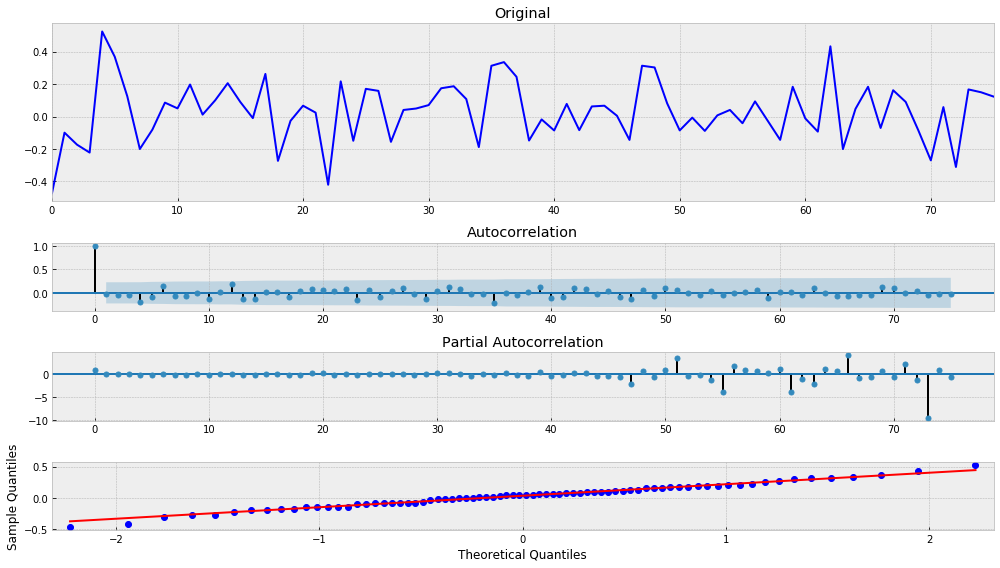

In [9]:
tsplot(mdl.resid)

Применим GARCH

In [10]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = order[0]
o_ = order[1]
q_ = order[2]

# Using student T distribution usually provides better fit
am = arch_model(series, p=p_, o=o_, q=q_, dist='StudentsT', vol='GARCH')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                      -0.001
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                            GARCH   Log-Likelihood:               -21.9291
Distribution:      Standardized Student's t   AIC:                           59.8582
Method:                  Maximum Likelihood   BIC:                           78.5041
                                              No. Observations:                   76
Date:                      Thu, Feb 13 2020   Df Residuals:                       68
Time:                              11:18:57   Df Model:                            8
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

Results of Dickey-Fuller Test:
Test Statistic                 -3.135644
p-value                         0.024025
#Lags Used                     11.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


/home/truename/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


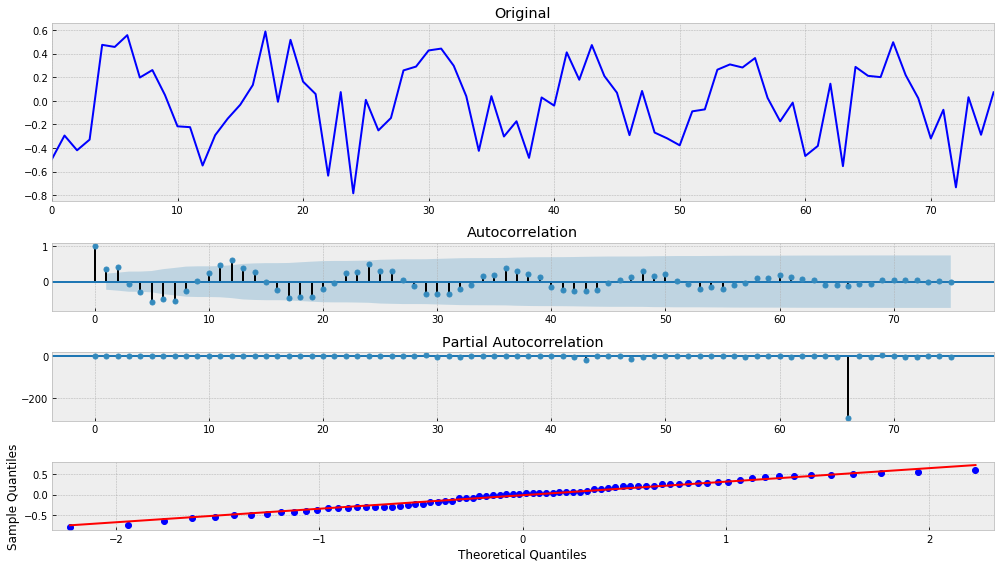

In [11]:
tsplot(res.resid)

И ее прогноз:

In [12]:
def add_lags(data, lag_start=5, lag_end=20):
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Count.shift(i)
    
    return data

def prepareData(data, lag_start=5, lag_end=20, test_size=0.15, use_lags=1):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    if use_lags == 1:
        data = add_lags(data, lag_start, lag_end)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Month"], axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Count"], axis=1)
    y_train = data.loc[:test_index]["Count"]
    X_test = data.loc[test_index:].drop(["Count"], axis=1)
    y_test = data.loc[test_index:]["Count"]
    
    return X_train, X_test, y_train, y_test

In [13]:
X_train, X_test, y_train, y_test = prepareData(df, lag_start=1, lag_end=20, test_size=0.3, use_lags=0)

/home/truename/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.002e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


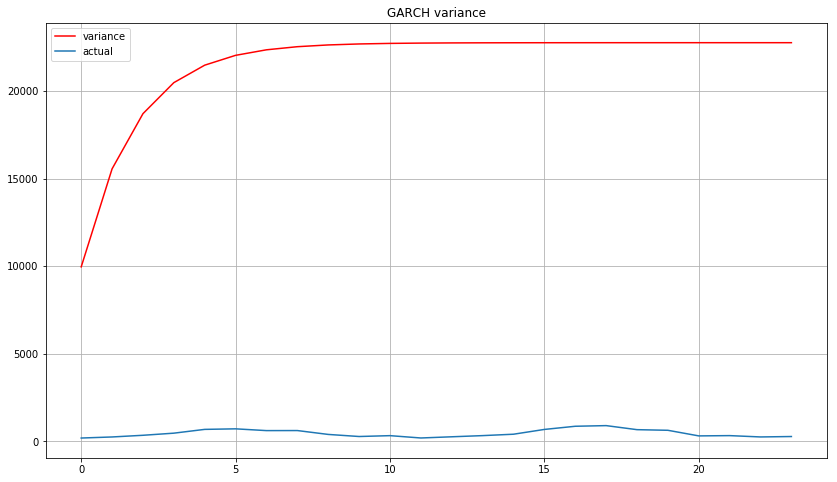

In [14]:
#train on X_train
am = arch_model(y_train.values, p=p_, o=o_, q=q_, dist='StudentsT', vol='GARCH')
res = am.fit(update_freq=5, disp='off')
prediction = res.forecast(horizon=len(X_test)).variance.values[-1, :]

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="variance")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("GARCH variance")
plt.grid(True);

### LinearRegression

Проверим самую простую модель линейной регрессии на обогащенных признаках:

In [15]:
X_train, X_test, y_train, y_test = prepareData(df, lag_start=1, lag_end=20, test_size=0.3, use_lags=1)

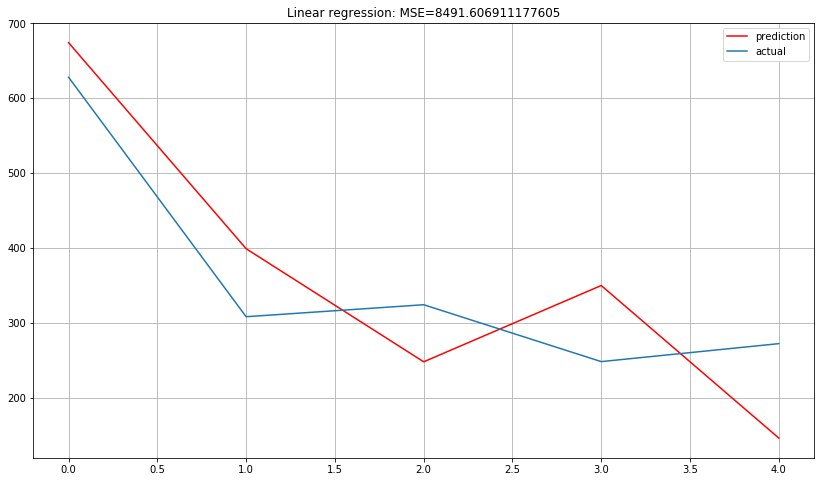

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title(f"Linear regression: MSE={mean_squared_error(y_test,prediction)}")
plt.grid(True);

### RandomForest

Сравним со случайным лесом:

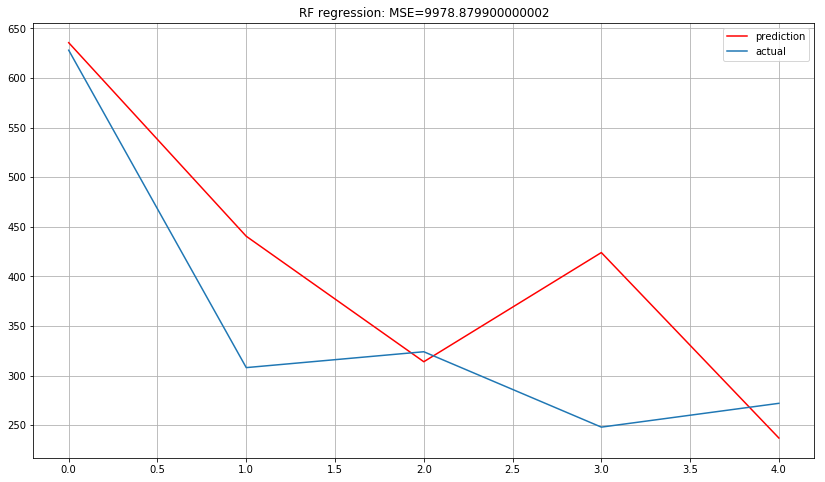

In [17]:
rf = RandomForestRegressor(n_estimators=100, max_depth=50)
rf.fit(X_train, y_train)
prediction = rf.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title(f"RF regression: MSE={mean_squared_error(y_test,prediction)}")
plt.grid(True);

In [18]:
RANDOM_STATE = 777
N_FOLDS = 3
param_grid = {'n_estimators': list(range(50,250,50)),
              'max_depth': list(range(5,25,5)),
              'min_samples_leaf': list(range(1,31,10)),
              'max_features': list(np.linspace(0.6,1,5)),
             }
print(param_grid)

{'n_estimators': [50, 100, 150, 200], 'max_depth': [5, 10, 15, 20], 'min_samples_leaf': [1, 11, 21], 'max_features': [0.6, 0.7, 0.8, 0.9, 1.0]}


In [19]:
from sklearn.model_selection import GridSearchCV
model_rf_grd = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE)
grid = GridSearchCV(model_rf_grd, param_grid, cv=N_FOLDS, n_jobs=-1)

{'max_depth': 15, 'max_features': 0.8, 'min_samples_leaf': 1, 'n_estimators': 200}


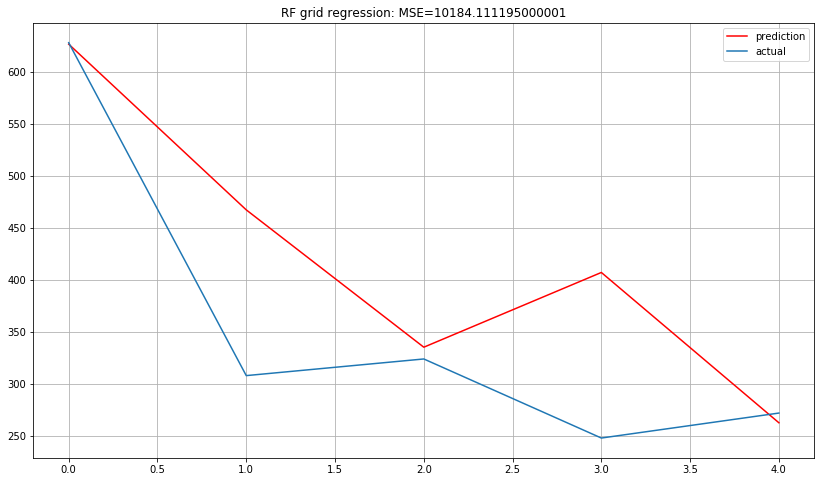

In [20]:
# fit the grid with data
grid.fit(X_train, y_train)
print(grid.best_params_)
# Get the model with the best params
model_rf = grid.best_estimator_
model_rf.fit(X_train, y_train)
prediction = model_rf.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title(f"RF grid regression: MSE={mean_squared_error(y_test,prediction)}")
plt.grid(True);

Линейная регрессия показала лучший результат!